<div align="center">

# Lista 5

</div>

<div align="center" style="">

### Importy

</div>

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
import numpy as np

<div align="center" style="">

### Wczytanie danych oraz przerobienie ich

</div>

In [8]:
df = pd.read_csv('Titanic Dataset.csv')

df = df[['survived','pclass','sex','age','sibsp','parch','fare','embarked']]

df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])
df['fare'] = df['fare'].fillna(df['fare'].median())

label_encoders = {}

for col in ['sex', 'embarked']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=['survived'])
y = df['survived']

<div align="center" style="">

### Podzielenie danych na testowe i treningowe

</div>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

<div align="center" style="">

### Funkcje służące zmienające zmienne numeryczne na kategoryczne

</div>

In [10]:
from sklearn.cluster import KMeans

def fit_equal_width(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_width(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_equal_freq(X_train, k):
    bins = {}
    for col in ['age','sibsp','parch','fare']:
        try:
            _, edges = pd.qcut(X_train[col], q=k, retbins=True, duplicates='drop')
        except ValueError:
            # za mało unikalnych wartości - fallback do cut
            _, edges = pd.cut(X_train[col], bins=k, retbins=True, duplicates='drop')
        bins[col] = edges
    return bins

def transform_equal_freq(X, bins):
    Xq = X.copy()
    for col, edges in bins.items():
        Xq[col] = pd.cut(Xq[col], bins=edges, labels=False, include_lowest=True)
    return Xq

def fit_kmeans(X_train, k):
    models = {}
    for col in ['age','sibsp','parch','fare']:
        km = KMeans(n_clusters=k, random_state=0)
        km.fit(X_train[[col]])
        models[col] = km
    return models

def transform_kmeans(X, models):
    Xq = X.copy()
    for col, km in models.items():
        Xq[col] = km.predict(X[[col]])
    return Xq


<div align="center" style="">

### Ewaluacja

</div>

In [11]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score

def evaluate(method, k):
    fit_obj = method['fit'](X_train, k)
    X_train_q = method['transform'](X_train, fit_obj)
    X_test_q  = method['transform'](X_test, fit_obj)

    model = CategoricalNB()
    model.fit(X_train_q, y_train)
    y_pred = model.predict(X_test_q)

    return accuracy_score(y_test, y_pred)


dsdsa

In [13]:
methods = {
    "equal_width": {
        "fit": fit_equal_width,
        "transform": transform_equal_width
    },
    "equal_freq": {
        "fit": fit_equal_freq,
        "transform": transform_equal_freq
    },
    "kmeans": {
        "fit": fit_kmeans,
        "transform": transform_kmeans
    }
}

results = []

print(methods.items())

for method_name, method_funcs in methods.items():
    for k in [2, 5, 10, 25]:
        acc = evaluate(method_funcs, k)
        results.append([method_name, k, acc])

import pandas as pd
results_df = pd.DataFrame(results, columns=["method", "k", "accuracy"])
print(results_df)


dict_items([('equal_width', {'fit': <function fit_equal_width at 0x000002761098C720>, 'transform': <function transform_equal_width at 0x000002761098D940>}), ('equal_freq', {'fit': <function fit_equal_freq at 0x000002761098D3A0>, 'transform': <function transform_equal_freq at 0x000002761098E8E0>}), ('kmeans', {'fit': <function fit_kmeans at 0x000002761098EE80>, 'transform': <function transform_kmeans at 0x000002761098DEE0>})])
         method   k  accuracy
0   equal_width   2  0.729008
1   equal_width   5  0.729008
2   equal_width  10  0.740458
3   equal_width  25  0.706107
4    equal_freq   2  0.717557
5    equal_freq   5  0.717557
6    equal_freq  10  0.732824
7    equal_freq  25  0.721374
8        kmeans   2  0.717557
9        kmeans   5  0.736641
10       kmeans  10  0.725191
11       kmeans  25  0.725191


c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (25). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\base.py:1365: ConvergenceWarning: Number of distinct 

<div align="center">

## Zadanie 2

</div>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def analyze_dataset(path):
    # Wczytaj macierz n x 2
    X = np.load(path)   # np.array o wymiarze (n, 2)

    # ---------- KMeans ----------
    kmeans = KMeans(n_clusters=3, random_state=0)
    labels_km = kmeans.fit_predict(X)

    # ---------- GMM ----------
    gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=0)
    labels_gmm = gmm.fit_predict(X)

    # ---------- Wizualizacja ----------
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(X[:,0], X[:,1], c=labels_km, s=20)
    axs[0].set_title("K-Means clustering")

    axs[1].scatter(X[:,0], X[:,1], c=labels_gmm, s=20)
    axs[1].set_title("Gaussian Mixture Model")

    plt.suptitle(path)
    plt.show()

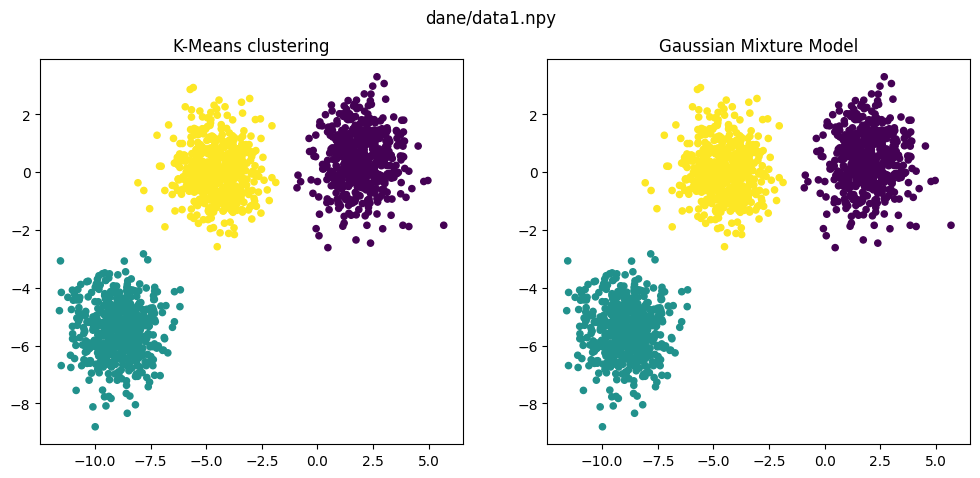

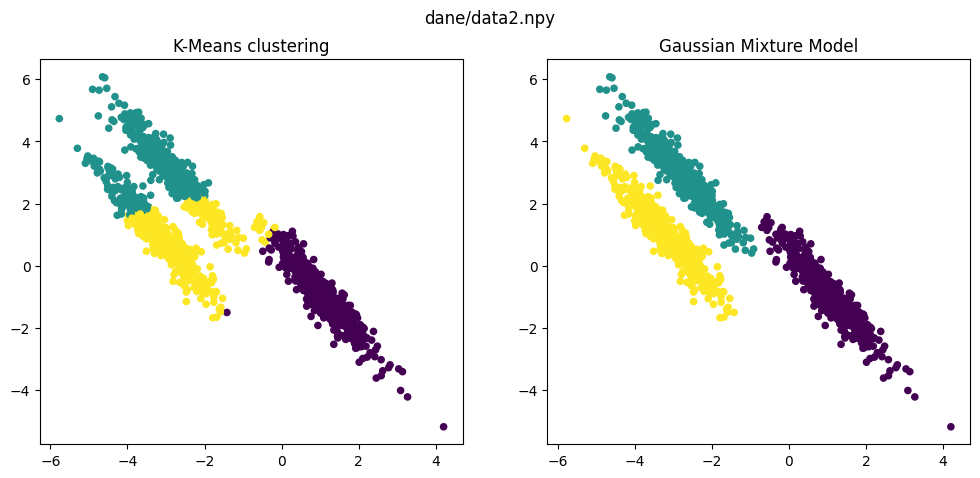

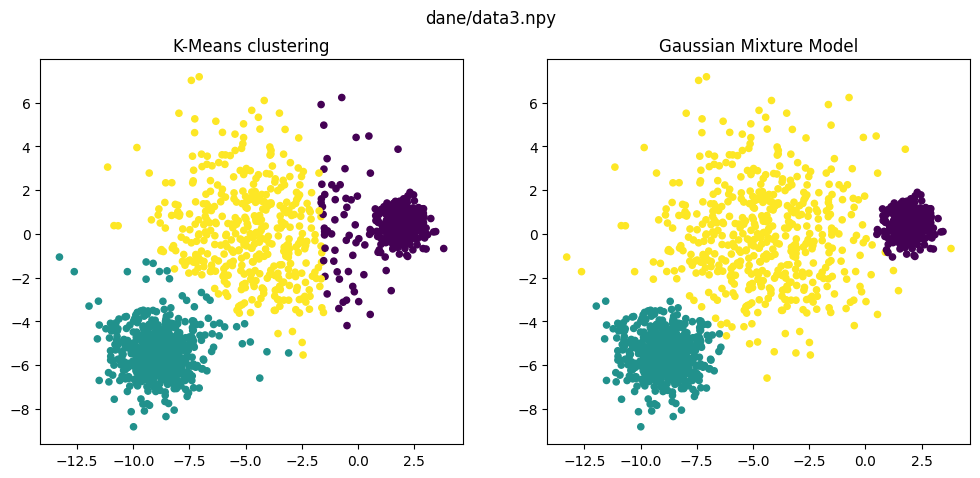

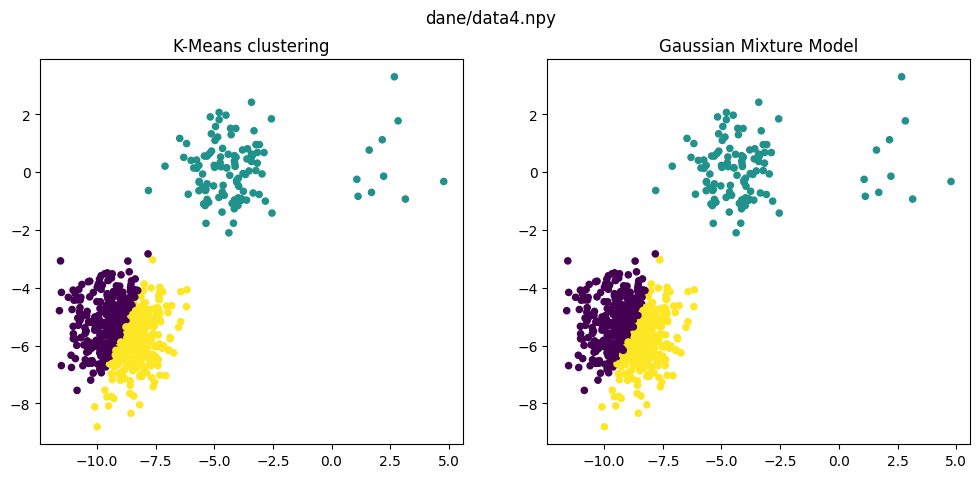

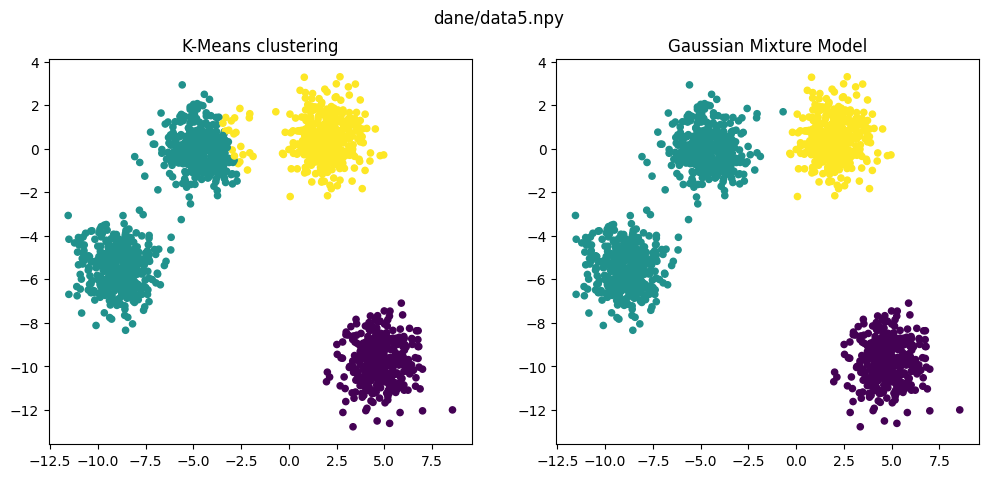

In [10]:
for i in range(1, 6):
    analyze_dataset(f"dane/data{i}.npy")


<div align="center">

## Zadanie 3

</div>

In [90]:
import numpy as np

images = np.load('dane/image_emb.npy')
images_lable = np.load('dane/image_labels.npy', allow_pickle=True)
images_test = np.load('dane/image_emb_test.npy')
images_labels_test = np.load('dane/image_labels_test.npy', allow_pickle=True)


labled_idx = np.where(images_lable != '')
mask = images_lable != ''
classes = np.unique(images_lable[images_lable != ''])


print(classes)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


# Tworzenie modelu

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from collections import Counter

kmeans = KMeans(n_clusters=len(classes), random_state=69)
clussters = kmeans.fit_predict(X=images)

def get_clusster_to_class(c, il):
    clusster_to_class = [Counter() for _ in range(len(classes))]

    for num, cls in zip(c, il):
        clusster_to_class[num][cls] += 1

    print(clusster_to_class)

    return {i: clusster_to_class[i].most_common()[0][0] for i in range(len(clusster_to_class))}


hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

res = [hash_map[c] for c in clussters]

test_clusters = kmeans.predict(X=images_test)
test_pred = [hash_map[c] for c in test_clusters]


acc = accuracy_score(images_labels_test, test_pred)

print("(K-MEANS) Accuracy:", acc)

# gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=69)
# clussters = gmm.fit_predict(X=images)

# hash_map = get_clusster_to_class(clussters[labled_idx], images_lable[labled_idx])

# res = [hash_map[c] for c in clussters]

# test_clusters = gmm.predict(X=images_test)
# test_pred = [hash_map[c] for c in test_clusters]


# acc = accuracy_score(images_labels_test, test_pred)

# print("(GMM) Accuracy:", acc)

[Counter({'airplane': 3, 'ship': 2, 'automobile': 1}), Counter({'deer': 5, 'cat': 1}), Counter({'ship': 3}), Counter({'airplane': 2}), Counter({'frog': 5}), Counter({'automobile': 4}), Counter({'horse': 5}), Counter({'dog': 5, 'cat': 4, 'bird': 1}), Counter({'truck': 5}), Counter({'bird': 4})]
(K-MEANS) Accuracy: 0.7513333333333333


c:\Piotr Pijanowski\Studia\Semestr-5\uczenie_maszynowe\lista_5\.venv\Lib\site-packages\sklearn\mixture\_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


[Counter({'truck': 4, 'automobile': 4, 'ship': 4, 'airplane': 1}), Counter({'dog': 5, 'horse': 5, 'cat': 3, 'airplane': 2, 'automobile': 1, 'truck': 1, 'ship': 1}), Counter({'deer': 5, 'frog': 5, 'bird': 5, 'cat': 2, 'airplane': 2}), Counter(), Counter(), Counter(), Counter(), Counter(), Counter(), Counter()]


IndexError: list index out of range

<div align="center">

## Zadanie 4

</div>